In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

Read the data from GP, XGB, and FFNN

In [2]:
df = pd.read_csv("comparison.csv")

Read the ChemProp data

In [3]:
cp_df = pd.read_csv("cp_comparison.csv")

Merge the two datasets

In [4]:
df = df.merge(cp_df,on=["dataset","split"])

Label the datasets with random and scaffold splits

In [5]:
df['random'] = [x.startswith("RND") for x in df.split]

Split the datasets into two dataframes, one for scaffold splits and one for random splits

In [6]:
df_rnd = df.query("random")
df_scaf = df.query("random == False")

In [7]:
df_rnd

,dataset,split,gp_r2,xgb_r2,ffnn_r2,gp_rmse,xgb_rmse,ffnn_rmse,cp_r2,cp_rmse,random
0,A2a,RND_00,0.752814,0.563589,0.698693,0.675240,0.897209,0.745505,0.691364,0.754518,True
1,A2a,RND_01,0.595350,0.214099,0.475207,0.856176,1.193183,0.975028,0.544874,0.908007,True
2,A2a,RND_02,0.617880,0.394742,0.542728,0.809310,1.018556,0.885324,0.501567,0.924311,True
3,A2a,RND_03,0.688750,0.687382,0.643147,0.675124,0.676605,0.722891,0.597276,0.767949,True
4,A2a,RND_04,0.496913,-0.027546,0.315573,0.633364,0.905175,0.738747,-0.066595,0.922214,True
...,...,...,...,...,...,...,...,...,...,...,...
465,opioid,RND_05,0.629443,0.561676,0.553482,0.697372,0.758464,0.765521,0.593799,0.730142,True
466,opioid,RND_06,0.758506,0.664784,0.716350,0.599983,0.706885,0.650245,0.718595,0.647667,True
467,opioid,RND_07,0.671188,0.580889,0.595497,0.699050,0.789221,0.775345,0.606756,0.764478,True
468,opioid,RND_08,0.706622,0.615326,0.681160,0.658198,0.753684,0.686166,0.670479,0.697564,True


In [8]:
df_scaf

,dataset,split,gp_r2,xgb_r2,ffnn_r2,gp_rmse,xgb_rmse,ffnn_rmse,cp_r2,cp_rmse,random
10,A2a,SCAF_00,0.012976,-0.301353,-0.095231,1.044128,1.198912,1.099873,-0.112249,1.108385,False
11,A2a,SCAF_01,0.374401,0.386379,-0.015330,0.690116,0.683478,0.879180,0.395728,0.678251,False
12,A2a,SCAF_02,0.597798,0.757998,0.748772,1.059375,0.821745,0.837262,-0.008850,1.677804,False
13,A2a,SCAF_03,0.287627,-0.280969,0.344380,0.840977,1.127716,0.806782,-0.246763,1.112557,False
14,A2a,SCAF_04,0.642142,0.685189,0.710857,1.040471,0.975887,0.935257,0.464790,1.272439,False
...,...,...,...,...,...,...,...,...,...,...,...
475,opioid,SCAF_05,0.640667,0.520661,0.594092,0.668501,0.772103,0.710505,0.550631,0.747575,False
476,opioid,SCAF_06,0.784424,0.603436,0.710162,0.578612,0.784773,0.670912,0.661084,0.725494,False
477,opioid,SCAF_07,0.640238,0.557889,0.555669,0.761375,0.844028,0.846145,0.647301,0.753865,False
478,opioid,SCAF_08,0.589945,0.512827,0.462945,0.833841,0.908874,0.954271,0.544184,0.879138,False


A simple function to count the number of lines in a file, we'll use this to order the datasets from smallest to largest

In [9]:
def count_lines(file_name):
    return sum(1 for line in open(file_name))

Put the datasets in order from smallest to largest

In [10]:
line_counts = [[x.split("/")[-1].replace(".smi",""),count_lines(x)] for x in glob("data/*.smi")]
df_line_count = pd.DataFrame(line_counts,columns=['dataset','count'])
df_line_count.sort_values("count",inplace=True)
sort_order = df_line_count.dataset.values

Create the y-axis labels for the boxplots with the number of molecules in the dataset and the dataset name

In [11]:
target_labels = [f"{a} {b}" for a,b in df_line_count[["dataset","count"]].values]

A function to draw boxplots showing performance over multiple folds of cross validation

In [12]:
def draw_boxplots(df,title):
    r2_cols = ["dataset"] + [x for x in df.columns if x.find("r2") > 0]
    rms_cols = ["dataset"] + [x for x in df.columns if x.find("rms") > 0]
    r2_df = df[r2_cols].melt(id_vars="dataset")
    rms_df = df[rms_cols].melt(id_vars="dataset")
    r2_df.columns = ['Dataset',"algorithm","R2"]
    rms_df.columns = ['Dataset',"algorithm","RMSE"]
    r2_df['Method'] = [x.split("_")[0].upper() for x in r2_df.algorithm]
    rms_df['Method'] = [x.split("_")[0].upper() for x in rms_df.algorithm]
    sns.set(rc={'figure.figsize': (15, 18)})
    sns.set_context('talk')
    ax = sns.boxplot(x="R2",y="Dataset",data=r2_df,orient="h",hue="Method",order=sort_order)
    for i in range(0,len(df.dataset.unique())):
        ax.axhline(0.5+i,linestyle="--",color="grey")
    ax.set(xlabel="R${^2}$")
    ax.set(yticklabels=target_labels)
    ax.set(title=title)
    plt.show()
    plt.tight_layout()
    ax.figure.savefig(title.replace(" ","_")+"_r2.png",bbox_inches='tight')
    ax = sns.boxplot(x="RMSE",y="Dataset",data=rms_df,orient="h",hue="Method",order=sort_order)
    for i in range(0,len(df.dataset.unique())):
        ax.axhline(0.5+i,linestyle="--",color="grey")
    ax.set(title=title)
    ax.set(yticklabels=target_labels)
    plt.show()
    ax.figure.savefig(title.replace(" ","_")+"_rmse.png",bbox_inches='tight');

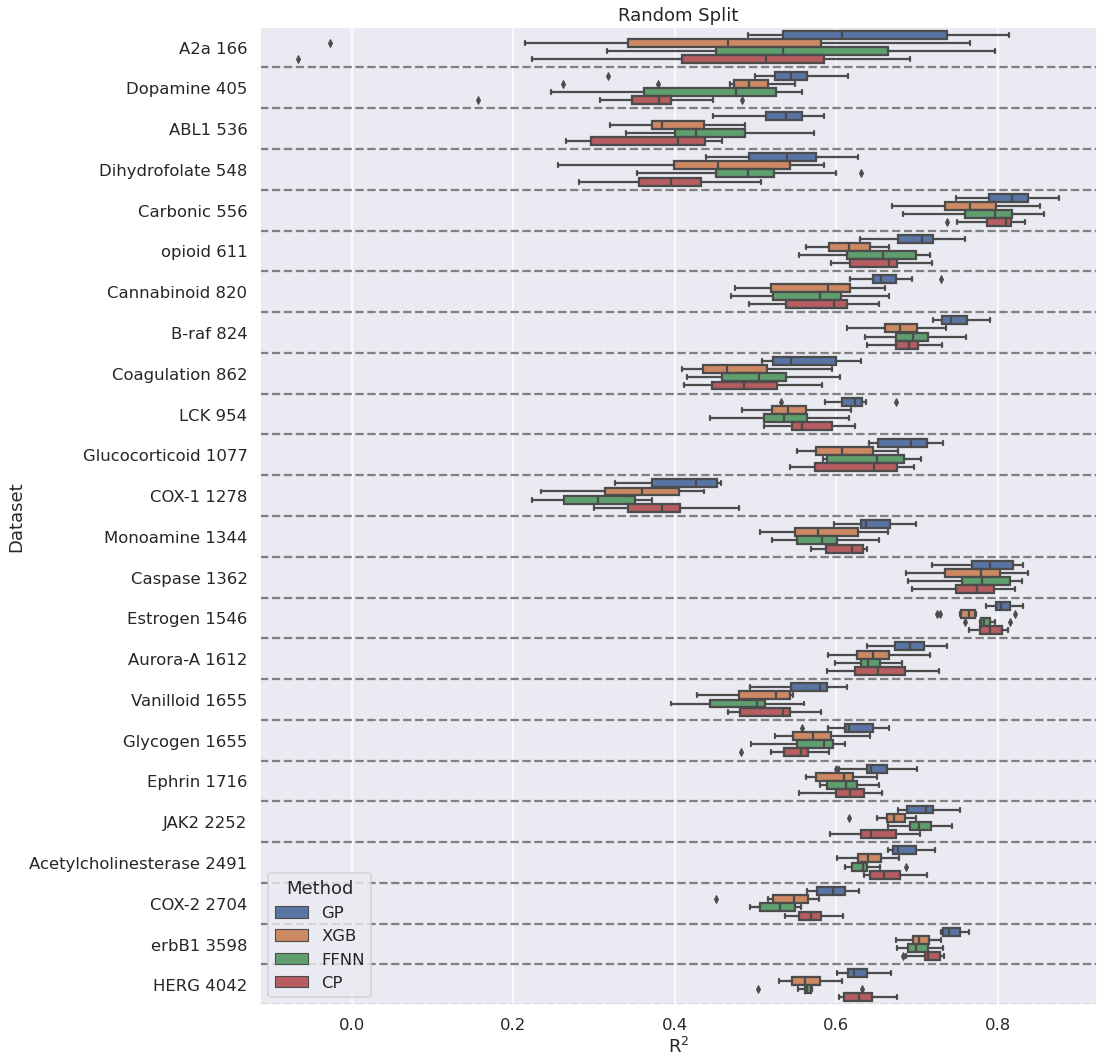

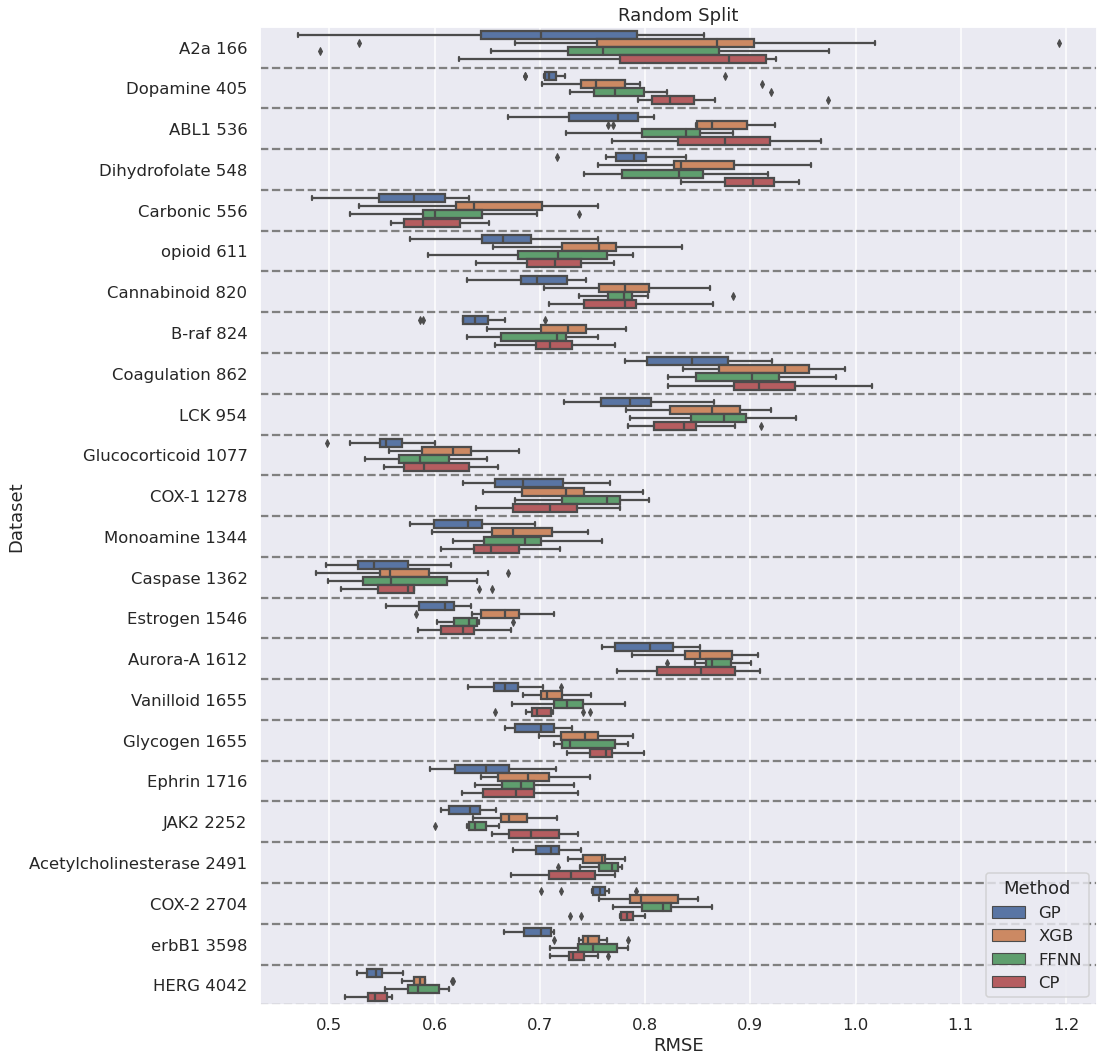

In [13]:
draw_boxplots(df_rnd,"Random Split")

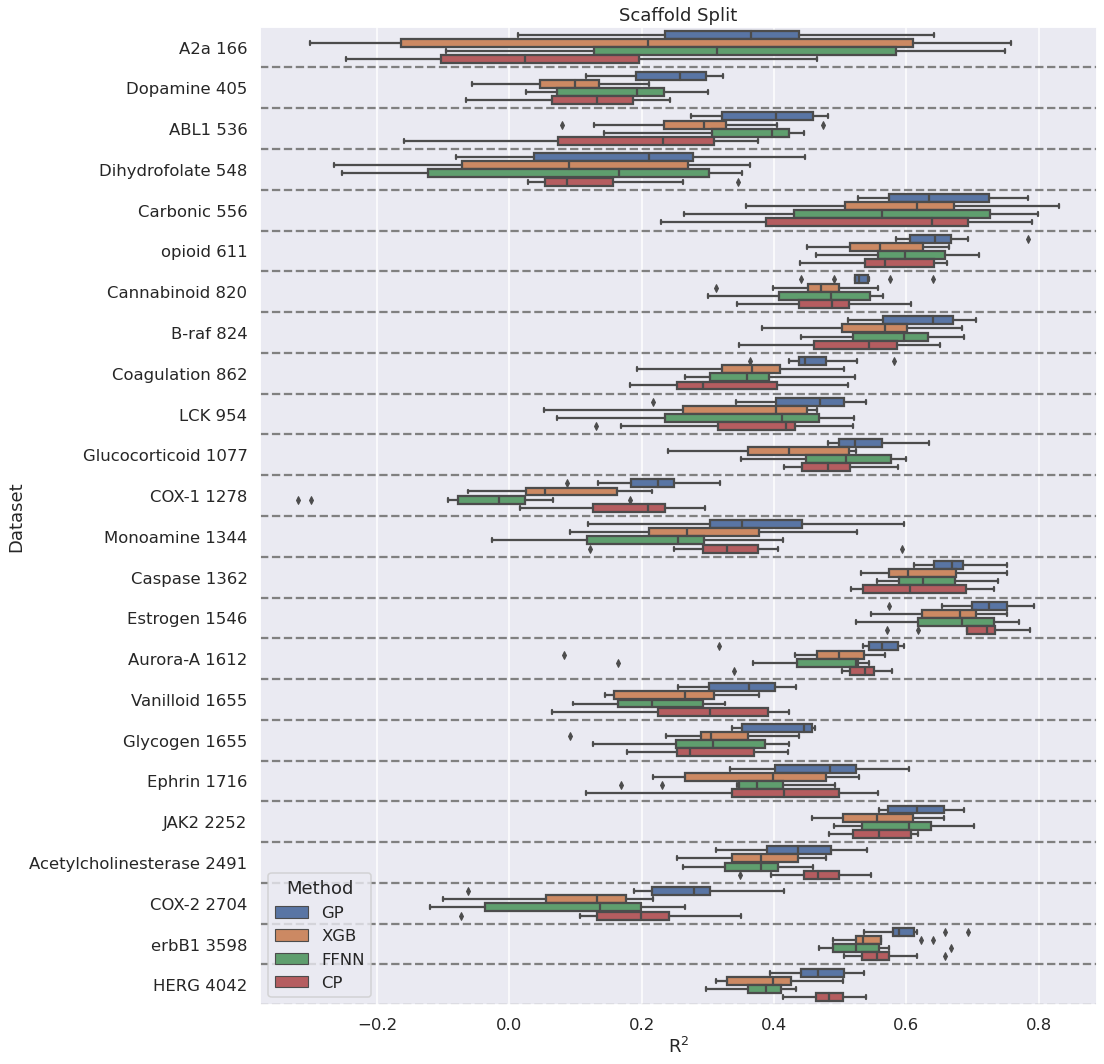

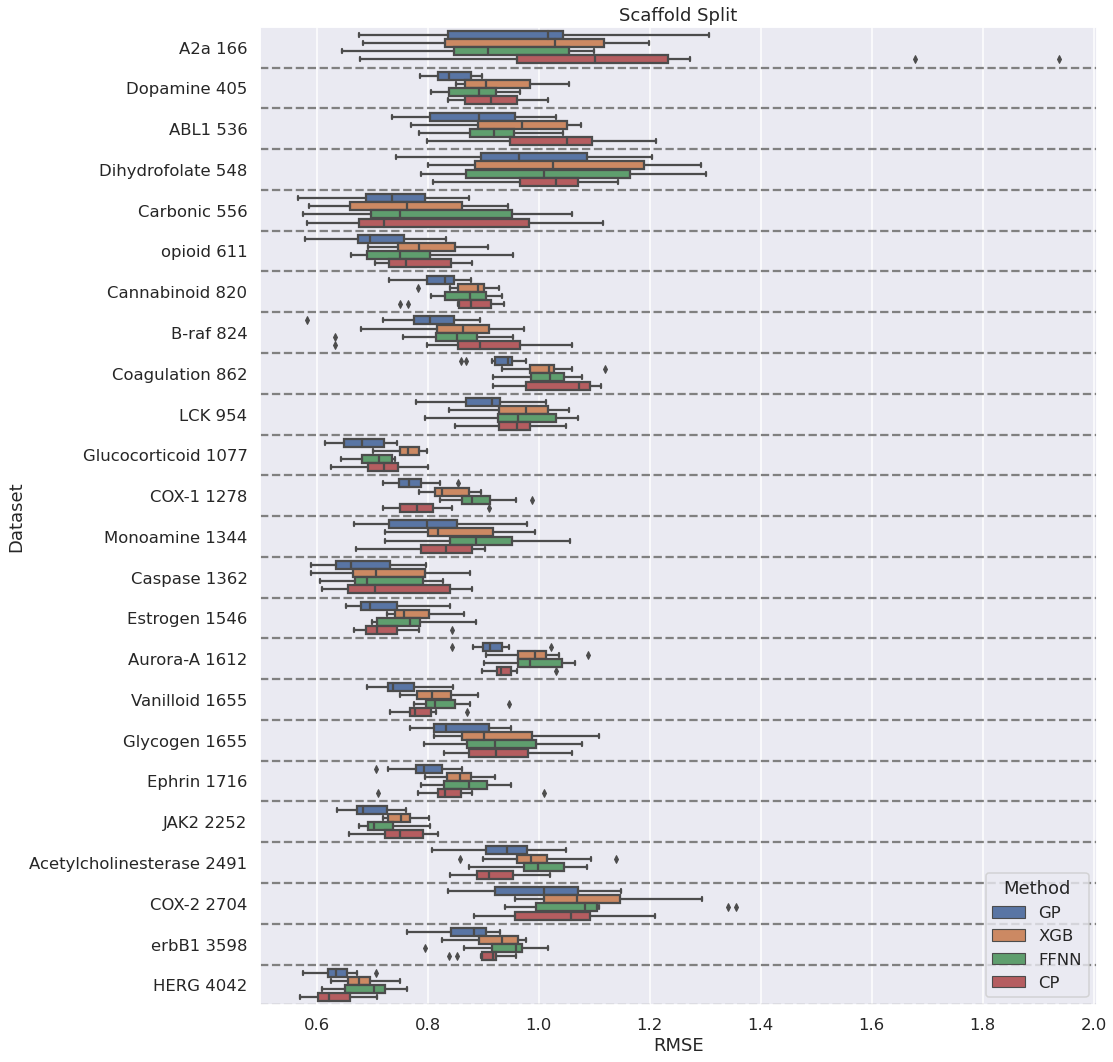

In [14]:
draw_boxplots(df_scaf,"Scaffold Split")